# StreamFlex customer churn predictions using Decision Trees and Random Forests

- **Demographics**: Age, Location, Subscription Length
- **Usage Behavior**: Watch Time, Number of Logins, Preferred Content Type
- **Subscription Details**: Membership Type (Basic, Standard, Premium), Payment Method, Payment Issues
- **Customer Support Interactions**: Number of Complaints, Resolution Time

Analyze and model customer churn using Decision Trees and Random Forests
and evaluate model performance using appropriate classification metrics.

## Section 2: Python Impl - Building the model

### Task 1: Data Preparation and Exploration


------------------------------Displaying summary statistics------------------------------
        CustomerID         Age  Subscription_Length_Months  Watch_Time_Hours  \
count  1000.000000  1000.00000                 1000.000000       1000.000000   
mean    500.500000    43.81900                   18.218000        100.794546   
std     288.819436    14.99103                   10.177822         56.477606   
min       1.000000    18.00000                    1.000000          5.036738   
25%     250.750000    31.00000                    9.000000         50.383080   
50%     500.500000    44.00000                   18.000000        100.234954   
75%     750.250000    56.00000                   27.000000        150.445885   
max    1000.000000    69.00000                   35.000000        199.944192   

       Number_of_Logins  Payment_Issues  Number_of_Complaints  \
count       1000.000000     1000.000000           1000.000000   
mean          50.387000        0.154000              4.546

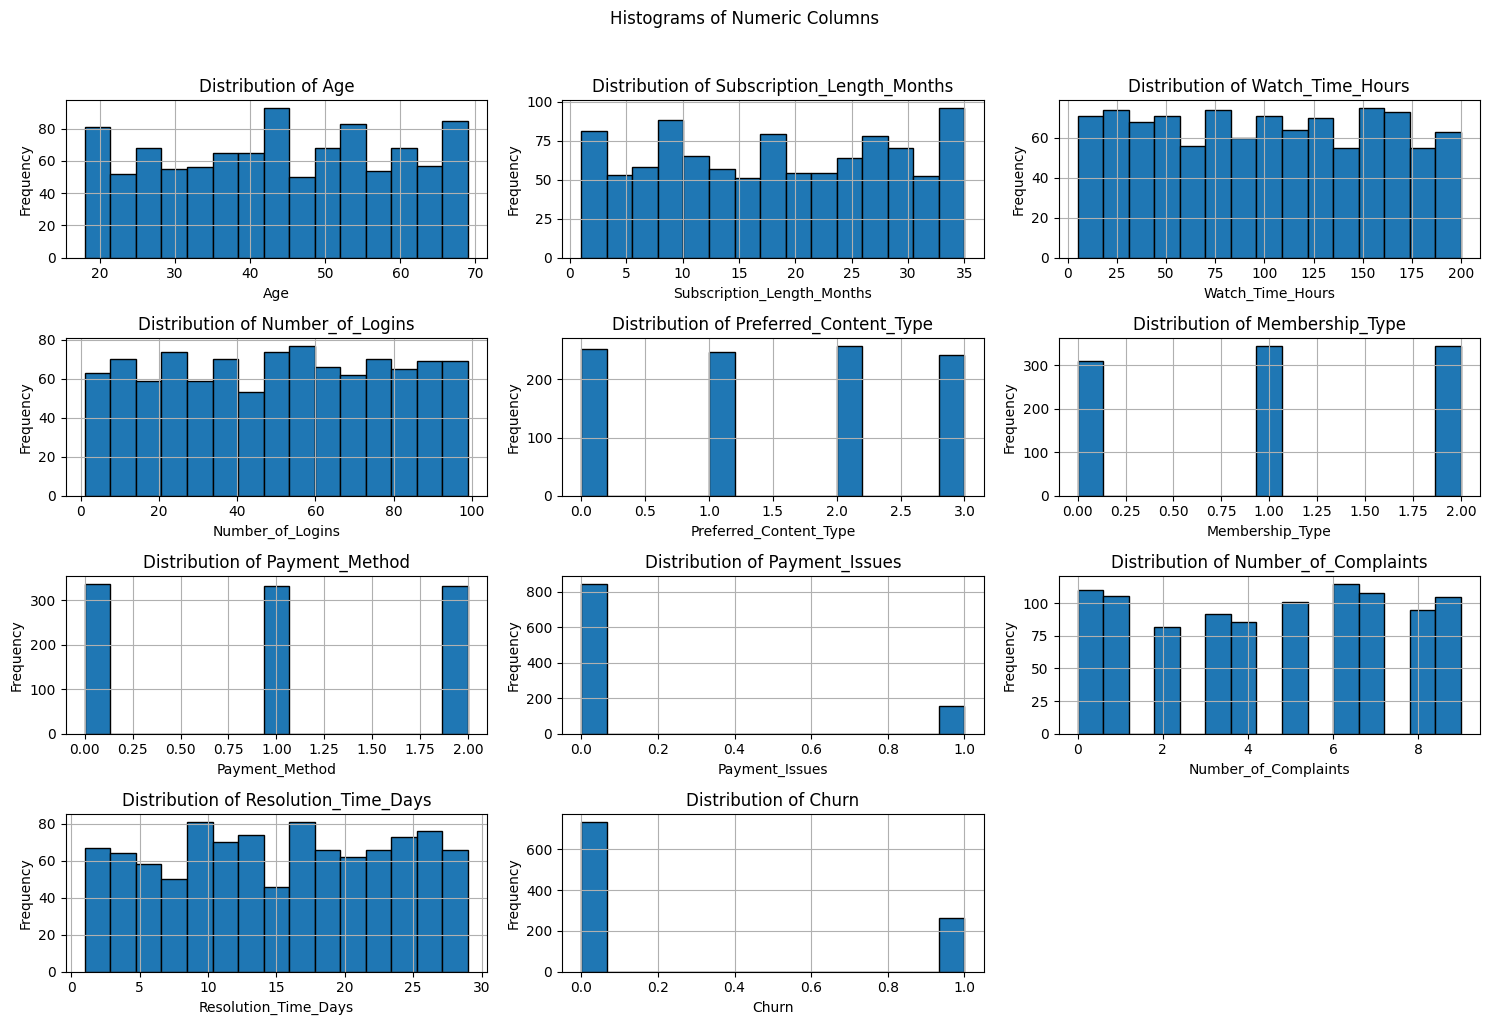

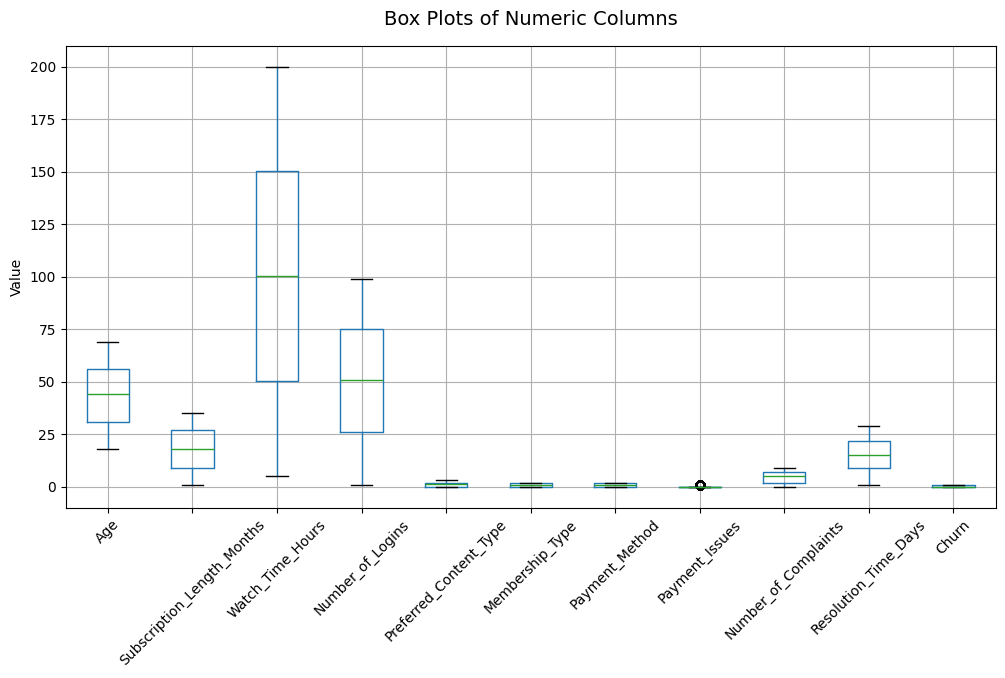


------------------------------Checking for correlations between variables------------------------------


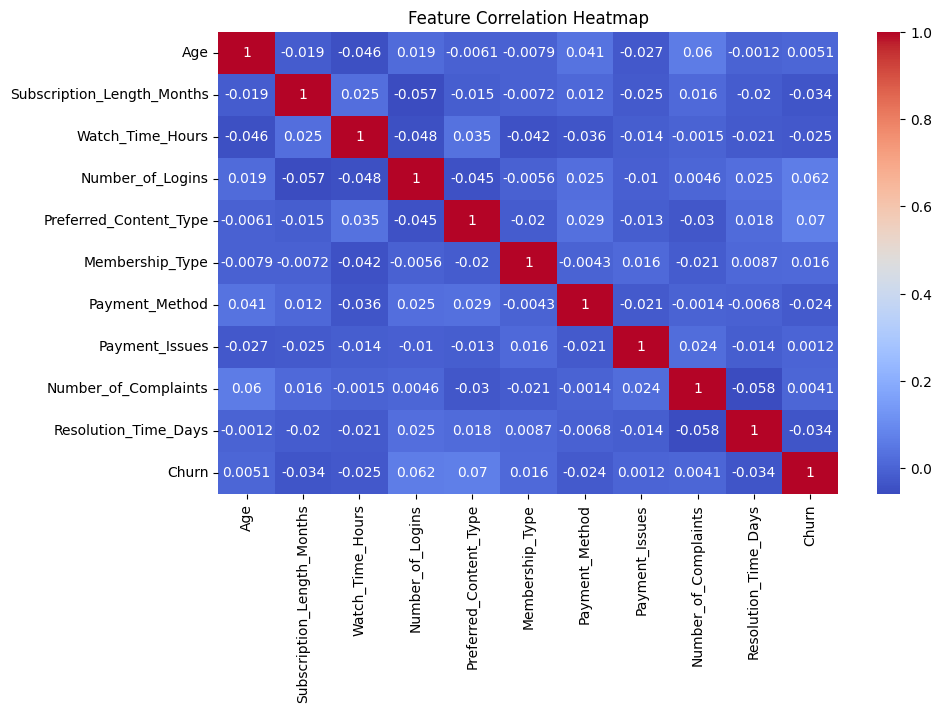

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Load the dataset
# Reads the CSV file containing the customer churn data
df = pd.read_csv("customer_churn.csv")

# 2. Display descriptive statistics
# By default, df.describe() shows a statistical summary (count, mean, std, min, quartiles, max) for numeric columns.
print('\n------------------------------Displaying summary statistics------------------------------')
print(df.describe())

# 3. Identify missing values
# df.isnull().sum() returns the count of missing (NaN) values in each column.
print('\n------------------------------Identifying missing values------------------------------')
print(df.isnull().sum())

# 4. Handle missing values
#    a) Fill numeric columns with their median value
#       This helps minimize the impact of outliers compared to using the mean.
df.fillna(df.median(numeric_only=True), inplace=True)

#    b) Fill remaining missing values with the mode
#       This is common for categorical columns; the "most frequent" value replaces NaNs.
df.fillna(df.mode().iloc[0], inplace=True)

# 5. Convert categorical variables to numerical using Label Encoding
#    Most machine learning algorithms require numeric inputs rather than categorical strings.
#    LabelEncoder() maps each unique categorical value to an integer.
label_encoders = {}
categorical_cols = ["Preferred_Content_Type", "Membership_Type", "Payment_Method"]

for col in categorical_cols:
    le = LabelEncoder()
    # fit_transform learns the mapping from strings to integers and applies it to the column
    df[col] = le.fit_transform(df[col])
    # Store the encoder if you need to invert (integer -> string) later
    label_encoders[col] = le

# 6. Visualize data distributions: histograms and box plots
#    Gives a quick overview of how numeric features are distributed and if there are outliers.

print('\n------------------------------Visualizing data distributions------------------------------')

# 6a. Histograms
#    Creates a grid of subplots, each showing a histogram for one numeric column.
#    "bins=15" can be adjusted depending on how much detail you want in each histogram.
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop("CustomerID", errors="ignore")

fig, axes = plt.subplots(nrows=len(numeric_cols) // 3 + 1, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    df[col].hist(ax=ax, bins=15, edgecolor="black")
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

# Hide empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Histograms of Numeric Columns", y=1.02)
plt.tight_layout()
plt.show()

# 6b. Box Plots
#    Displays box plots for each numeric column side-by-side.
#    Box plots show quartiles, median, and potential outliers.

plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot()
plt.title("Box Plots of Numeric Columns", fontsize=14, pad=15)
plt.xticks(rotation=45)
plt.ylabel("Value")
plt.show()

# 7. Correlation heatmap
#    Shows pairwise correlation coefficients between numeric features.
#    "annot=True" displays the numerical correlation values in each cell.
#    "cmap='coolwarm'" sets the color palette.
print('\n------------------------------Checking for correlations between variables------------------------------')
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(columns=['CustomerID']).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

### Task 2 Building a Decision Tree classifier

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best hyperparameters: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Decision Tree Accuracy: 0.435
Decision Tree Precision: 0.2169811320754717
Decision Tree Recall: 0.4339622641509434
Decision Tree F1 Score: 0.2893081761006289
Decision Tree Confusion Matrix:
 [[64 83]
 [30 23]]


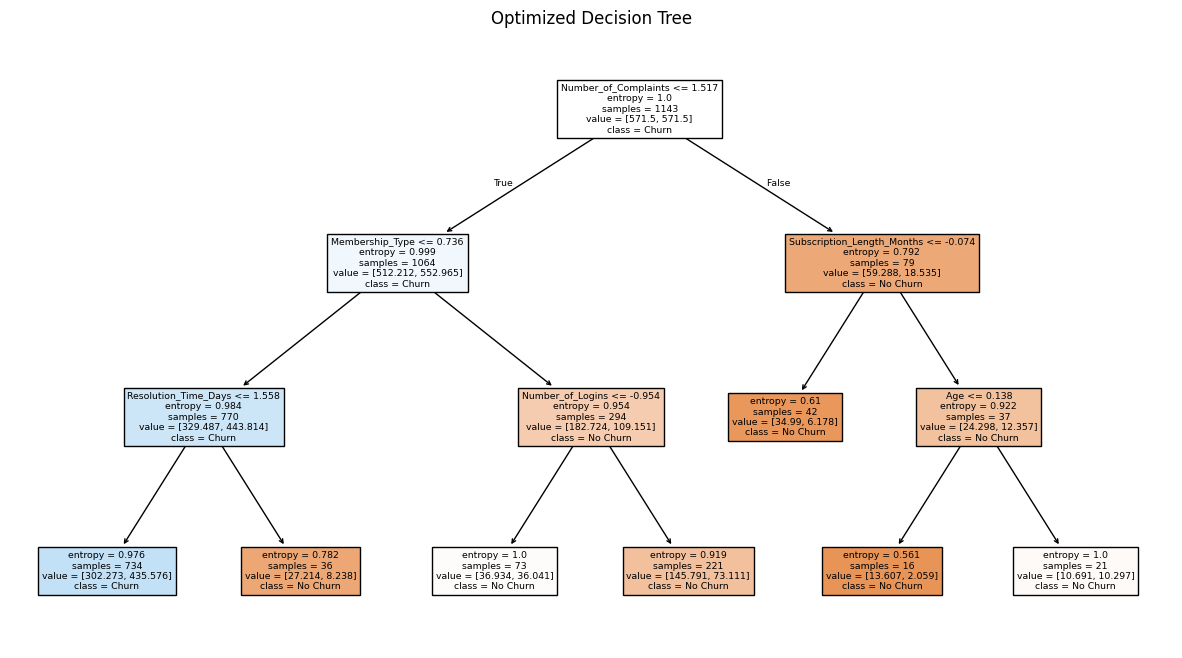

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

# Data preparation
# Split features and target, excluding CustomerID as it's redundant
x = df.drop(columns=["CustomerID", "Churn"])
y = df["Churn"]

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handling class imbalance using SMOTE
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# Initialize ADASYN
adasyn = ADASYN(random_state=42)

# Apply ADASYN to resample the dataset
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
# X_train_res, y_train_res = X_train, y_train
# Feature scaling (Standardizing numeric features)
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
numeric_transformer = StandardScaler()

# One-hot encoding for categorical features
categorical_features = X.select_dtypes(include=["object"]).columns
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Combine numeric and categorical transformations into a single preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Create a pipeline that includes preprocessing and decision tree
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt)
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [3, 5, 7, 10, None],  # Max depth to prevent overfitting
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4, 8],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__max_features': [None, "sqrt", "log2"]
}

# Run GridSearchCV with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5), scoring='recall', verbose=3, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# Display the best hyperparameters from GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Prune the tree using cost complexity pruning
path = best_model.named_steps['classifier'].cost_complexity_pruning_path(X_train_res, y_train_res)
ccp_alphas = path.ccp_alphas[1:-1]  # Remove extreme values for alpha

# Find the best alpha using cross-validation
alpha_scores = []
for alpha in ccp_alphas:
    dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    scores = cross_val_score(dt_pruned, X_train_res, y_train_res, cv=5, scoring='recall')
    alpha_scores.append((alpha, scores.mean()))

best_alpha = max(alpha_scores, key=lambda x: x[1])[0]
best_model.named_steps['classifier'].ccp_alpha = best_alpha

# Fit the final model on the training data
best_model.fit(X_train_res, y_train_res)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Print the performance metrics
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print("Decision Tree Precision:", precision_score(y_test, y_pred))
print("Decision Tree Recall:", recall_score(y_test, y_pred))
print("Decision Tree F1 Score:", f1_score(y_test, y_pred))
print("Decision Tree Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize the decision tree
plt.figure(figsize=(15, 8))
plot_tree(best_model.named_steps['classifier'], feature_names=X.columns, class_names=["No Churn", "Churn"], filled=True)
plt.title("Optimized Decision Tree")
plt.show()


### Task 3 Improving Performance,overfitting,etc.... with Random Forests

===========VALIDATION=============
Mean Recall (Validation): 0.3487
Mean Precision (Validation): 0.3218
Mean F1 Score (Validation): 0.3330
Mean Accuracy (Validation): 0.6238


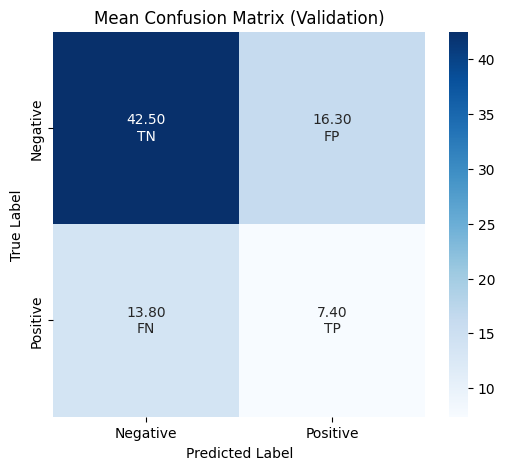

===========TESTING=============
              precision    recall  f1-score   support

           0       0.75      0.32      0.45       147
           1       0.27      0.70      0.39        53

    accuracy                           0.42       200
   macro avg       0.51      0.51      0.42       200
weighted avg       0.62      0.42      0.43       200

Random Forest Accuracy (Test): 0.42
Random Forest Precision (Test): 0.27007299270072993
Random Forest Recall (Test): 0.6981132075471698
Random Forest F1 Score (Test): 0.3894736842105263


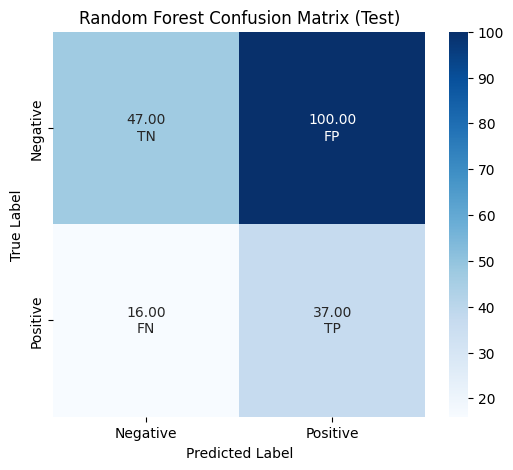

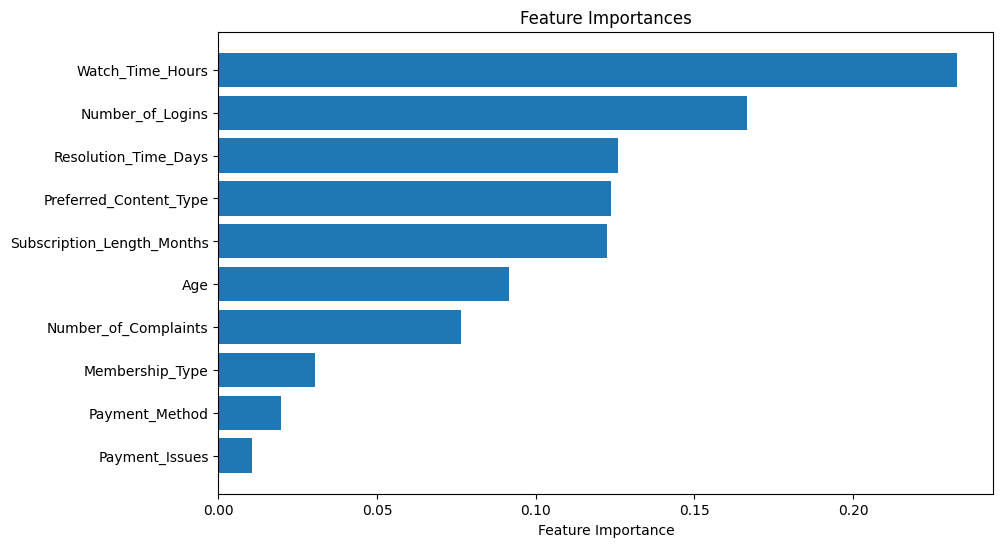

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, cross_validate
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from enum import Enum, auto

# Enum for different cross-validation strategies
class CrossValidationEnum(Enum):
    NONE = auto()
    BUILTIN = auto()
    CUSTOM = auto()

# Configuration parameters
DO_HYPERPARAM_TUNING = False                    # Toggle hyperparameter optimization
PARTIAL_GRIDSEARCHCV_NUM_ITERS = 80            # Number of iterations for grid search
USE_PREDICT_PROBA_FOR_TEST_DATASET = True       # Use probability predictions for test set
TEST_PROBA_THRESHOLD = 0.46                     # Threshold for probability predictions
CROSS_VALIDATION_TYPE = CrossValidationEnum.CUSTOM  # Selected cross-validation strategy

# Data preparation
# Split features and target, excluding CustomerID as it's redundant
x = df.drop(columns=["CustomerID", "Churn"])
y = df["Churn"]

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Define cross-validation strategy with 10 folds
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Hyperparameter grid focused on recall
param_grid = {
    'n_estimators': [100, 200, 300],           # More trees for stability
    'max_depth': [3, 5, 10],                   # Control overfitting
    'min_samples_split': [2, 5, 10, 14, 20],   # Ensure minority class gets split
    'min_samples_leaf': [2, 3, 5, 8],          # Avoid too-small leaves
    'max_features': ['sqrt', None],            # Reduce overfitting
    'criterion': ['entropy'],                  # Focus on information gain
}

# Calculate sample weights to handle class imbalance
SAMPLE_WEIGHT = compute_sample_weight("balanced", y_train)

# Model training with optional hyperparameter tuning
if DO_HYPERPARAM_TUNING:
    rf = RandomForestClassifier(random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(rf, param_grid, cv=cv_strategy, scoring='recall', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    print("Best Recall:", grid_search.best_score_)
    print("Best Hyperparameters: ", grid_search.best_params_)

    # Retrain with sample weights
    grid_search.fit(X_train, y_train, sample_weight=SAMPLE_WEIGHT)
    print("NOW WITH SAMPLE WEIGHTS")
    print("Best Recall:", grid_search.best_score_)
    print("Best Hyperparameters: ", grid_search.best_params_)
    best_rf = grid_search.best_estimator_
else:
    # Use pre-optimized parameters
    recall_best_params_ = {
        'criterion': 'entropy',
        'max_depth': 3,
        'max_features': 'sqrt',
        'min_samples_leaf': 2,
        'min_samples_split': 10,
        'n_estimators': 200,
        'bootstrap': True
    }
    best_rf = RandomForestClassifier(**recall_best_params_, class_weight="balanced", random_state=42)
    best_rf.fit(X_train, y_train, sample_weight=SAMPLE_WEIGHT)

# Visualization functions
def display_pretty_confusion_matrix(conf_matrix, *, title: str):
    """
    Display a formatted confusion matrix with TN, FP, FN, TP labels
    Args:
        conf_matrix: The confusion matrix to display
        title: Title for the plot
    """
    labels = np.array([['TN', 'FP'], ['FN', 'TP']])
    annot_labels = np.array([[f'{conf_matrix[0, 0]:.2f}\n{labels[0, 0]}', f'{conf_matrix[0, 1]:.2f}\n{labels[0, 1]}'],
                            [f'{conf_matrix[1, 0]:.2f}\n{labels[1, 0]}', f'{conf_matrix[1, 1]:.2f}\n{labels[1, 1]}']])

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=annot_labels, fmt="", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Cross-validation evaluation functions
def CrossValidate_Builtin_Driver():
    """
    Perform built-in cross-validation with multiple metrics
    Returns evaluation metrics for each fold
    """
    scoring_metrics = {
        'accuracy': 'accuracy',
        'recall': make_scorer(recall_score),
        'precision': make_scorer(precision_score),
        'f1': make_scorer(f1_score)
    }

    # Function to compute confusion matrix
    def compute_confusion_matrix(estimator, X, y):
        y_pred = estimator.predict(X)
        return confusion_matrix(y, y_pred)

    # Run cross-validation and collect multiple metrics and confusion matrices
    cv_results = cross_validate(best_rf, X_train, y_train, cv=cv_strategy,
                              scoring=scoring_metrics, params={"sample_weight": SAMPLE_WEIGHT},
                              return_estimator=True)

    print("Cross-validation results:")
    for metric in scoring_metrics:
        print(f"{metric.capitalize()} scores: {cv_results['test_' + metric]}")
        print(f"Mean {metric}: {cv_results['test_' + metric].mean():.4f}")
        print(f"Std {metric}: {cv_results['test_' + metric].std():.4f}\n")

    print(f"Mean Fit Time: {cv_results['fit_time'].mean():.4f} seconds")
    print(f"Std Fit Time: {cv_results['fit_time'].std():.4f} seconds")

    # Calculate confusion matrices for each fold and plot them
    for fold, estimator in enumerate(cv_results['estimator']):
        cm = compute_confusion_matrix(estimator, X_train, y_train)
        print(f"Confusion Matrix for fold {fold + 1}:")
        print(cm)
        print()

# Perform cross-validation if enabled
if CROSS_VALIDATION_TYPE != CrossValidationEnum.NONE:
    if CROSS_VALIDATION_TYPE == CrossValidationEnum.BUILTIN:
        print("===========VALIDATION=============")
        CrossValidate_Builtin_Driver()
    elif CROSS_VALIDATION_TYPE == CrossValidationEnum.CUSTOM:
        # Initialize metrics storage
        recall_scores = []
        precision_scores = []
        f1_scores = []
        accuracy_scores = []
        conf_matrix_sum = np.zeros((2, 2))

        # Perform k-fold cross-validation
        for train_idx, val_idx in cv_strategy.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            best_rf.fit(X_train_fold, y_train_fold)
            y_val_pred = best_rf.predict(X_val_fold)

            # Calculate and store metrics
            recall_scores.append(recall_score(y_val_fold, y_val_pred))
            precision_scores.append(precision_score(y_val_fold, y_val_pred))
            f1_scores.append(f1_score(y_val_fold, y_val_pred))
            accuracy_scores.append(accuracy_score(y_val_fold, y_val_pred))

            cm = confusion_matrix(y_val_fold, y_val_pred)
            conf_matrix_sum += cm

        # Print average validation scores
        print("===========VALIDATION=============")
        print(f"Mean Recall (Validation): {sum(recall_scores) / len(recall_scores):.4f}")
        print(f"Mean Precision (Validation): {sum(precision_scores) / len(precision_scores):.4f}")
        print(f"Mean F1 Score (Validation): {sum(f1_scores) / len(f1_scores):.4f}")
        print(f"Mean Accuracy (Validation): {sum(accuracy_scores) / len(accuracy_scores):.4f}")
        # Plot mean confusion matrix
        mean_conf_matrix = conf_matrix_sum / cv_strategy.get_n_splits()
        display_pretty_confusion_matrix(mean_conf_matrix, title="Mean Confusion Matrix (Validation)")

# Probability threshold estimation
def Estimate_Predict_Proba_Threshold():
    """
    Estimate optimal probability threshold using precision-recall curve
    Returns predicted labels and optimal threshold
    """
    probs = cross_val_predict(best_rf, X_train, y_train, cv=cv_strategy, method='predict_proba')
    precision, recall, thresholds = precision_recall_curve(y_train, probs[:, 1])
    optimal_threshold = thresholds[np.argmax(precision + recall)]
    y_pred_optimal = (probs[:, 1] > optimal_threshold).astype(int)

    # Apply optimal threshold to make predictions
    print("Optimal Threshold:", optimal_threshold)
    print("Optimal Precision:", precision[np.argmax(precision + recall)])
    print("Optimal Recall:", recall[np.argmax(precision + recall)])
    return y_pred_optimal, optimal_threshold

# Final model evaluation on test set
print("===========TESTING=============")

if USE_PREDICT_PROBA_FOR_TEST_DATASET:
    y_probs = best_rf.predict_proba(X_test)[:, 1]
    threshold = TEST_PROBA_THRESHOLD
    y_pred = (y_probs >= threshold).astype(int)
else:
    y_pred = best_rf.predict(X_test)

# Calculate and display final metrics
print(classification_report(y_test, y_pred))
print("Random Forest Accuracy (Test):", accuracy_score(y_test, y_pred))
print("Random Forest Precision (Test):", precision_score(y_test, y_pred))
print("Random Forest Recall (Test):", recall_score(y_test, y_pred))
print("Random Forest F1 Score (Test):", f1_score(y_test, y_pred))

display_pretty_confusion_matrix(confusion_matrix(y_test, y_pred), title="Random Forest Confusion Matrix (Test)")

# Visualizing the importance of features in the Random Forest
importances = best_rf.feature_importances_
indices = importances.argsort()

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(x.shape[1]), importances[indices], align="center")
plt.yticks(range(x.shape[1]), x.columns[indices])
plt.xlabel("Feature Importance")
plt.show()

